Постановка задачи:

На вход приходит запрос и список товаров. Нужно отранжировать товары по релевантности запросу на основании фичей, не учитывающих пользовательскую статистику.

Что такое релевантность? Для маркетплейса самый релевантный товар это тот, который лучше всегда продаётся по данному запросу
Есть разные способы отвечтать на вопрос, какой товар продаётся лучше, а какой хуже, с какими весами учитывать число просмотров, добавлений в корзину и так далее, но в конечном итоге для товаров в рамках одного запроса предсказывается какой-то score, по которому товары ранжируются в выдаче до применения фильтров, рекламы и тому подобного.

Задача: по запросу и набору товаров выдать отранжированный список товаров
Ограничения на товары: по товаром нет информации о поведении пользователей (товары-новинки)

Какое ранжирование считаем правильным? 
Истинное ранжирование - такое, какое было бы у этих товаров после накопления пользовательской статистики.

Это значит, что истинное ранжирование неизвестно, поэтому ставим задачу следующим образом:
берём запрос и список товаров с известными скорами, то есть с пользовательской статистикой, убираем данные о поведении пользователей, но основании оставшихся данных предсказываем отранжированный список товаров по скорам.

Как измеряем качество:
стандартные метрики качества ранжирования https://habr.com/ru/company/econtenta/blog/303458/
Mean average precision at K
Normalized Discounted Cumulative Gain at K
Возможно PFound и Mean reciprocal rank

Данные: Amazon product data http://deepyeti.ucsd.edu/jianmo/amazon/index.html, 12 Gb of meta data, ? rows

features: title, brand, description, price, photos, category
target: salesRank in category

Что такое salesRank? https://sellics.com/blog-amazon-sales-rank/
Это значение максимально близко по смыслу к score товара в выдаче до применения фильтров, рекламы и тому подобного

Какие модели используем?
1. Baseline:
берём готовые эмбеддинги category + title, brand и description, 
поверх них линейный слой 
и учим на них XGBRanker 

2. Усложнение модели:
* готовые эмбеддинги category + title, brand и description, поверх них небольшой dssm и учим на них XGBRanker 
* Bert for learning to rank

In [35]:
import pandas as pd
import gzip
import json
import seaborn as sns
import numpy as np
import time
import html
import re
from tqdm import trange
import os
from typing import *
from tqdm import tqdm, trange

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

        
def getPandasDataFrame(path, limit=None):
    i = 0
    df = {}
    try:
        for d in tqdm(parse(path)):
            df[i] = d
            i += 1
            if limit is not None and i >= limit:
                break
    except KeyboardInterrupt:
        pass
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
%%time
meta_electronics = getPandasDataFrame('meta_Electronics.json.gz', limit=None)

786445it [12:33, 1043.87it/s]


Wall time: 12min 44s


In [7]:
meta_electronics.iloc[0].imageURLHighRes

['https://images-na.ssl-images-amazon.com/images/I/411uoWa89KL.jpg']

### Загружаем одну фотографию

In [31]:
import urllib.request
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt

In [28]:
%%time
urllib.request.urlretrieve(meta_electronics.iloc[0].imageURLHighRes[0], 'image_test.jpg')
img = cv.imread('image_test.jpg')

Wall time: 163 ms


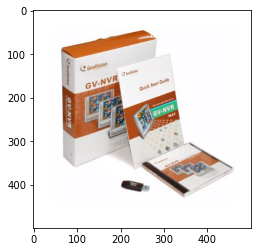

In [33]:
plt.imshow(img)
plt.show()

### Одну фотографию загрузить получилось. Теперь нужно загрузить много параллельно

In [ ]:
meta_electronics.shape

(786445, 19)

In [ ]:
meta_electronics.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Electronics, Camera &amp; Photo, Video Survei...",,[The following camera brands and models have b...,,Genuine Geovision 1 Channel 3rd Party NVR IP S...,[],,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[>#3,092 in Tools &amp; Home Improvement &gt; ...",[],Camera &amp; Photo,,"January 28, 2014",$65.00,0011300000,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Electronics, Camera &amp; Photo]",,[This second edition of the Handbook of Astron...,,"Books ""Handbook of Astronomical Image Processi...",[0999470906],,33 Books Co.,[Detailed chapters cover these fundamental top...,"[>#55,933 in Camera &amp; Photo (See Top 100 i...","[0943396670, 1138055360, 0999470906]",Camera &amp; Photo,,"June 17, 2003",,0043396828,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],Books,,,$11.49,0060009810,[],[],NaN
3,"[Electronics, eBook Readers & Accessories, eBo...",,[],,Hurray for Hattie Rabbit: Story and pictures (...,"[0060219521, 0060219580, 0060219394]",,Visit Amazon's Dick Gackenbach Page,[],"2,024,298 in Books (","[0060219521, 0060219475, 0060219394]",Books,,,.a-section.a-spacing-mini{margin-bottom:6px!im...,0060219602,[],[],NaN
4,"[Electronics, eBook Readers & Accessories, eBo...",,[&#8220;sex.lies.murder.fame. is brillllli&#82...,,sex.lies.murder.fame.: A Novel,[],,Visit Amazon's Lolita Files Page,[],"3,778,828 in Books (",[],Books,,,$13.95,0060786817,[],[],NaN


In [ ]:
meta_electronics = meta_electronics.drop_duplicates('title')
meta_electronics.shape

(742022, 19)

Посмотрим на товары одной категории

In [ ]:
category = meta_electronics.iloc[34532].main_cat
category

'Home Audio &amp; Theater'

In [ ]:
category_df = meta_electronics[meta_electronics['main_cat'] == category]

In [ ]:
def map_by_batches(df, func, batch_size = 2000):
    batch_results = []
    for i in trange(df.shape[0] // batch_size + 1):
        l = batch_size * i
        r = min(df.shape[0], l + batch_size)
        batch_results.append(func(df[l : r]))
    return pd.concat(batch_results)

In [ ]:
def extract_rank_and_category(data):
    rank_str = re.compile(">#[\d,]* in ")
    
    ranks = []
    categories = []

    description = []
    title = []
    brand = []
    feature = []
    price = []

    def extract(string):
        result = rank_str.match(string)
        if not result:
            return -1, ""
        rank = result.group(0)[2:-4]
        category = string[result.span()[1]:] 
        return int(rank.replace(',', '')), html.unescape(category)
    try:
        for i in range(data.shape[0]):
            string = data.iloc[i]['rank']
            if not isinstance(string, str):
                if not string:
                    continue
                else:
                    string_list = string
                    for string in string_list:
                        rank, category = extract(string)
                        if rank == -1:
                            continue
                        ranks.append(rank)
                        categories.append(category)
                        description.append(data.iloc[i]['description'])
                        title.append(data.iloc[i]['title'])
                        brand.append(data.iloc[i]['brand'])
                        feature.append(data.iloc[i]['feature'])
                        price.append(data.iloc[i]['price'])
            else:
                rank, category = extract(string)
                if rank == -1:
                    continue
                ranks.append(rank)
                categories.append(category)
                description.append(data.iloc[i]['description'])
                title.append(data.iloc[i]['title'])
                brand.append(data.iloc[i]['brand'])
                feature.append(data.iloc[i]['feature'])
                price.append(data.iloc[i]['price'])
    except KeyboardInterrupt:
        pass

    df = pd.DataFrame({'rank':np.array(ranks), 'category':np.array(categories), 
                                      'description':np.array(description), 'title':np.array(title),
                                      'brand':np.array(brand), 'feature':np.array(feature),
                                      'price':np.array(price)
                                     }, dtype=object)
    return df

In [ ]:
category_df.shape

(4657, 19)

In [ ]:
clear_category_df = map_by_batches(category_df, extract_rank_and_category)

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/1655359559.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/1655359559.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


In [ ]:
clear_category_df[clear_category_df['price'] != '']

,rank,category,description,title,brand,feature,price
0,79,Electronics > Accessories & Supplies > Camera ...,[TDK Hi8 MP120 Premium Performance Camcorder V...,TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Electronics Corp,[],$48.99
1,2802,Computers & Accessories > Computer Accessories...,[TDK Hi8 MP120 Premium Performance Camcorder V...,TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Electronics Corp,[],$48.99
10,1708,Computers & Accessories > Tablet Accessories >...,[HDTV Adapter Kit for NOOK HD and NOOK HD+\nTh...,Barnes &amp; Noble HDTV Adapter Kit for NOOK H...,Barnes &amp; Noble,[Connects NOOK to your high-definition televis...,$1.46
51,1681,Electronics > Accessories & Supplies > Audio &...,"[15 TRACKS: 1) A20 - Come On Over 2) A20, Nata...",Verbatim CDR 650MB 74MIN Media 16x (1-Pack wit...,Verbatim,[],$4.99
71,63,Computers & Accessories > Computer Accessories...,[Specially developed for professional studio a...,HHB MD80 80 Minute MiniDisc (Each),HHB,[],$8.95
...,...,...,...,...,...,...,...
1622,303582,Electronics > Home Audio & Theater,[DD Audios continuous search for the most conv...,DD Audio DXB-03 Studio Headphones,DD Audio,"[Natural Finish Bubinga Wood Housing, Deep Bas...",$8.60
1623,321177,Electronics > Portable Audio & Video > MP3 & M...,[DD Audios continuous search for the most conv...,DD Audio DXB-03 Studio Headphones,DD Audio,"[Natural Finish Bubinga Wood Housing, Deep Bas...",$8.60
1624,15888,Electronics > Accessories & Supplies > Audio &...,[Compatible With: Sharp LC-32GP1U LC-32GP3U-B ...,HQRP Remote Control for Sharp LC-32GP1U LC-32G...,HQRP,[HQRP Replacement Remote Control plus HQRP Coa...,$6.91
1625,36437,Electronics > Accessories & Supplies > Televis...,[Compatible With: Sharp LC-32GP1U LC-32GP3U-B ...,HQRP Remote Control for Sharp LC-32GP1U LC-32G...,HQRP,[HQRP Replacement Remote Control plus HQRP Coa...,$6.91


In [ ]:
category = clear_category_df.iloc[1232].category
category

'Cell Phones & Accessories > Cell Phone Accessories > Headphones > Over-Ear Headphones'

In [ ]:
df = clear_category_df[clear_category_df['category'] == category]
df

,rank,category,description,title,brand,feature,price
150,17596,Cell Phones & Accessories > Cell Phone Accesso...,[],KLH KHP201TW Digital Headphones,KLH,"[40-millimeter drivers with neodymium magnets,...",
277,16042,Cell Phones & Accessories > Cell Phone Accesso...,"[Includes RF stereophone, transmitter and AC p...",Koss JR900 Cordless Stereo Headphones (Discont...,Koss,"[Provides Wireless Listening, Transmits Throug...",
309,15733,Cell Phones & Accessories > Cell Phone Accesso...,[Digital Reference Series headphones derive th...,Sony MDRCD570 Digital Reference Headphones (Di...,Sony,"[Aura-nomic closed-ear design, 40-millimeter d...",
322,17566,Cell Phones & Accessories > Cell Phone Accesso...,[These headphones' wireless design lets you mo...,Sony MDRRF950RK Wireless Headphones (Discontin...,Sony,[Complete kit including transmitter and headph...,
549,11880,Cell Phones & Accessories > Cell Phone Accesso...,[Sennheiser's HD500 Fusion is a full-size head...,Sennheiser HD500 Open Fusion Full-Size Headpho...,Sennheiser,"[Over-ear, open-back stereo headphones, Single...",
...,...,...,...,...,...,...,...
1221,10013,Cell Phones & Accessories > Cell Phone Accesso...,[],Digital Stereo Headphones w- In-Line Volume Co...,MaxiAids,[],
1271,6512,Cell Phones & Accessories > Cell Phone Accesso...,"[Designed exclusively for the professional DJ,...",Utrasone DJ1 PRO (Discontinued by Manufacturer),Ultrasone,[S-Logic(TM) Natural Surround Sound for a more...,
1322,16018,Cell Phones & Accessories > Cell Phone Accesso...,[Block out distracting background noise and en...,HP Mobile Noise Canceling Headphones (GF552AA#...,HP,[Tune out the outside world and enhance your l...,
1531,9277,Cell Phones & Accessories > Cell Phone Accesso...,[When you're rocking to the beats and jazzing ...,Sony MDR-XB300 Extra Bass Headphones,Sony,[30mm driver units - exclusively engineered by...,


Сравним самый хороший c произвольным 

In [ ]:
best_item = df[df['rank'] == df['rank'].min()].iloc[0]
item = df[df['rank'] == 11880].iloc[0]

In [ ]:
best_item.title

'Kidz Gear Wired Headphones For Kids - Green - CH68KG05'

In [ ]:
best_item['rank']

363

Ссылка на Amazon: https://www.amazon.com/Kidz-Gear-Wired-Headphones-Kids/dp/B00AXE9YD2

In [ ]:
item.title

'Sennheiser HD500 Open Fusion Full-Size Headphones (Black) (Discontinued by Manufacturer)'

In [ ]:
item['rank']

11880

Ссылка на Amazon: https://www.amazon.com/Sennheiser-HD500-Headphones-Discontinued-Manufacturer/dp/B00004SD87/ref=cm_cr_arp_d_product_top?ie=UTF8

Как видно, с точки зрения текстовой релевантности оба эти товара прекрасно подходят под запрос, но salesRank у них сильно различается

### Обработка данных

In [ ]:
meta_electronics_with_prices = meta_electronics[meta_electronics['price'] != '']
meta_electronics_with_prices.shape

(291809, 19)

#### Берём больше данных

In [ ]:
def simple_filter(df):
    df = df[df['price'] != '']
    df = df.drop_duplicates('title')
    print(df.shape)
    return df

In [ ]:
%%time
meta_All_Beauty = getPandasDataFrame('meta_All_Beauty.json.gz', limit=None)
meta_All_Beauty = simple_filter(meta_All_Beauty)

32892it [00:05, 5558.73it/s]


(11288, 19)
Wall time: 6.91 s


In [ ]:
%%time
meta_AMAZON_FASHION = getPandasDataFrame('meta_AMAZON_FASHION.json.gz', limit=None)
meta_AMAZON_FASHION = simple_filter(meta_AMAZON_FASHION)

186637it [00:31, 5999.37it/s] 


(175263, 16)
Wall time: 32.7 s


In [ ]:
%%time
meta_Appliances = getPandasDataFrame('meta_Appliances.json.gz', limit=None)
meta_Appliances = simple_filter(meta_Appliances)

30445it [01:14, 407.64it/s]


(19871, 19)
Wall time: 1min 17s


In [ ]:
%%time
meta_Arts_Crafts_and_Sewing = getPandasDataFrame('meta_Arts_Crafts_and_Sewing.json.gz', limit=None)
meta_Arts_Crafts_and_Sewing = simple_filter(meta_Arts_Crafts_and_Sewing)

302988it [00:51, 5901.68it/s] 


(182572, 19)
Wall time: 56 s


In [ ]:
meta_electronics_with_prices.shape

(291809, 19)

In [ ]:
meta_All_Beauty_clear = map_by_batches(meta_All_Beauty, extract_rank_and_category, batch_size = 20000)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


In [ ]:
meta_All_Beauty_clear.shape

(45, 7)

In [ ]:
meta_Appliances_clear = map_by_batches(meta_Appliances, extract_rank_and_category, batch_size = 20000)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


In [ ]:
meta_Appliances_clear.shape

(37774, 7)

In [ ]:
meta_Arts_Crafts_and_Sewing = map_by_batches(meta_Arts_Crafts_and_Sewing, extract_rank_and_category, batch_size = 20000)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


In [ ]:
meta_Arts_Crafts_and_Sewing.shape

(386893, 7)

In [ ]:
meta_electronics_clear = map_by_batches(meta_electronics_with_prices, extract_rank_and_category, batch_size = 20000)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'description':np.array(description), 'title':np.array(title),
C:\Users\artyo\AppData\Local\Temp/ipykernel_13284/3922156410.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'brand':np.array(brand), 'feature':np.array(feature),
100%|██████████| 15/15 [02:11<00:00,  8.79s/it]


In [ ]:
meta_electronics_clear.shape

(492901, 7)

In [ ]:
meta_electronics_clear.head()

,rank,category,description,title,brand,feature,price
0,3092,Tools & Home Improvement > Safety & Security >...,[The following camera brands and models have b...,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...",$65.00
1,5010,Tools & Home Improvement > Safety & Security >...,[The following camera brands and models have b...,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...",$65.00
2,950,Cell Phones & Accessories (See Top 100 in Cell...,"[, <b>True High Definition Sound:</b><br>With ...",Wireless Bluetooth Headphones Earbuds with Mic...,Enter The Arena,[Superb Sound Quality: Plays crystal clear aud...,$7.99
3,124,Cell Phones & Accessories > Cell Phone Accesso...,"[, <b>True High Definition Sound:</b><br>With ...",Wireless Bluetooth Headphones Earbuds with Mic...,Enter The Arena,[Superb Sound Quality: Plays crystal clear aud...,$7.99
4,387,Electronics > Home Audio & Theater,"[, <b>True High Definition Sound:</b><br>With ...",Wireless Bluetooth Headphones Earbuds with Mic...,Enter The Arena,[Superb Sound Quality: Plays crystal clear aud...,$7.99


In [ ]:
metadata_clear = pd.concat([meta_All_Beauty_clear, meta_Appliances_clear, meta_Arts_Crafts_and_Sewing, meta_electronics_clear])

In [ ]:
metadata_clear.shape

(917613, 7)

In [ ]:
metadata_clear.to_csv('metadata_clear.csv', index=False)

In [ ]:
metadata_clear.head()

,rank,category,description,title,brand,feature,price
0,175420,Beauty & Personal Care (See Top 100 in Beauty ...,[These extra long backscratcher/shoehorns are ...,BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,[A perfect gift for a friend who could use an ...,$9.95
1,132516,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,"[LABORATORY TESTED AND APPROVED, ULTRAVIOLET G...",$13.00
2,41845,Beauty & Personal Care (See Top 100 in Beauty ...,[Bring a natural element into your bathroom or...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,[VINTAGE LOOK: Silver finish steel wire toilet...,$24.37
3,302442,Grocery & Gourmet Food (See Top 100 in Grocery...,[. Simply heat bottle in a hot water bath unti...,F/X Gelatin-Graftobian,Graftobian,[F/X Gelatin is the ''heat and serve'' of gore...,$29.99
4,250013,Beauty & Personal Care (See Top 100 in Beauty ...,[BOOK LOVER Street Sign books novels readers r...,SignMission Book Lover Street Sign Books Novel...,SignMission,"[Sign Size: 4"" X 18"", Perfect Gift - Good for ...",$8.99


In [7]:
%%time
metadata_clear = pd.read_csv('metadata_clear.csv')

CPU times: total: 7.05 s
Wall time: 7.43 s


In [8]:
metadata_clear.shape

(917613, 7)

In [11]:
from nltk.corpus import stopwords
from string import punctuation
import nltk
nltk.download('stopwords')

print(stopwords.words('english'))
print(punctuation)

noise = stopwords.words('english') + list(punctuation)

print(len(noise))
noise = set(noise)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Препроцессинг предложений

In [15]:
metadata_clear.iloc[23].description

"['An ultrasonic cleaning is a process that uses ultrasound (usually from 20&#150;400 kHz) and an appropriate cleaning solvent (sometimes ordinary tap water) to clean items. The ultrasound can be used with just water, but use of a solvent appropriate for the item to be cleaned and the type of soiling present enhances the effect. Cleaning normally lasts between three and six minutes, but can also exceed 20 minutes, depending on the object to be cleaned.<br>The ultrasonic cleaning process provides high quality cleaning and exceeds, by ease of use and end result, conventional cleaning methods. The tiny microscopic bubbles generated by the transducers provide cleaning of very difficult, irregular and complex parts. Even inaccessible areas can be cleaned without any trace of physical cleaning (scratches, etc...). Special for cleaning electronic tool, jewelry, glasses, dental instruments, lab instruments, hospital instruments.<br>', '<strong>Specification:</strong>', '<strong>Package Content

In [20]:
metadata_clear.iloc[2].description.replace("['", "").replace("']", "")

'Bring a natural element into your bathroom or powder room with this modern, decorative free standing toilet paper holder<br><br> With a tall, compact shape, the storage tower can hold up to 3 toilet paper rolls with ease, while the top dispenser holds a single roll at just the right height<br><br> Perfect for tucking in between the toilet and bathroom vanity, the open access holder and tower allow toilet paper to be removed and replaced quickly and easily for hassle-free roll changes<br><br> Small metal feet raise the stand alone toilet roll holder slightly, keep your extra paper supply clean, dry and off the bathroom floor, while adding ornate detailing<br><br> The toilet roll holders strong construction and intricate design make it an attractive and functional storage choice<br><br> InterDesigns creative products enhance your dcor, turning simple home solutions into must-have accessories that shine<br><br> Designed in the USA, we are proud to produce a wide selection of high quality

In [28]:
! pip install beautifulsoup4

In [30]:
from bs4 import BeautifulSoup
cleantext = BeautifulSoup(str(metadata_clear.iloc[2].description.replace("['", "").replace("']", "")), "html.parser").text
cleantext

'Bring a natural element into your bathroom or powder room with this modern, decorative free standing toilet paper holder With a tall, compact shape, the storage tower can hold up to 3 toilet paper rolls with ease, while the top dispenser holds a single roll at just the right height Perfect for tucking in between the toilet and bathroom vanity, the open access holder and tower allow toilet paper to be removed and replaced quickly and easily for hassle-free roll changes Small metal feet raise the stand alone toilet roll holder slightly, keep your extra paper supply clean, dry and off the bathroom floor, while adding ornate detailing The toilet roll holders strong construction and intricate design make it an attractive and functional storage choice InterDesigns creative products enhance your dcor, turning simple home solutions into must-have accessories that shine Designed in the USA, we are proud to produce a wide selection of high quality home, bath and storage solutions that excite, i

In [ ]:
def get_filtered_sentence(sentence):
    cleantext = BeautifulSoup(str(sentence).replace("['", "").replace("']", ""), "html.parser").text
    return cleantext

In [31]:
# def get_filtered_sentence(sentence):
#     cleantext = BeautifulSoup(str(sentence), "lxml").text
#     filtered = []
#     for token in razdel.tokenize(cleantext):
#         word = token.text.lower()
#         if word not in noise:
#             filtered.append(word)
    
#     .replace("…", "").lower()
    
#     return ' '.join(filtered)
    
# def prepare_data(encoder: Encoder, data):
#     features, categories, target = [], []
#     skipped = 0
#     for i in trange(data.shape[0]):
# #         try:
#         row = data.iloc[i]
#         description = encoder.encode_sent(get_filtered_sentence(str(row.description)))
#         title = encoder.encode_sent(get_filtered_sentence(str(row.title)))
#         brand = encoder.encode_sent(get_filtered_sentence(str(row.brand)))
#         feature = encoder.encode_sent(get_filtered_sentence(str(row.feature)))

#         features.append(torch.cat((description, title, brand, feature)))
#         categories.append(row['category'])
#         target.append(row['rank'])
# #         except Exception:
# #             skipped += 1
# #     print(skipped)
#     return np.stack(features), np.array(categories), np.array(target)

In [32]:
print(metadata_clear.iloc[2].description)
print()
print(get_filtered_sentence(str(metadata_clear.iloc[2].description)))

['Bring a natural element into your bathroom or powder room with this modern, decorative free standing toilet paper holder<br><br> With a tall, compact shape, the storage tower can hold up to 3 toilet paper rolls with ease, while the top dispenser holds a single roll at just the right height<br><br> Perfect for tucking in between the toilet and bathroom vanity, the open access holder and tower allow toilet paper to be removed and replaced quickly and easily for hassle-free roll changes<br><br> Small metal feet raise the stand alone toilet roll holder slightly, keep your extra paper supply clean, dry and off the bathroom floor, while adding ornate detailing<br><br> The toilet roll holders strong construction and intricate design make it an attractive and functional storage choice<br><br> InterDesigns creative products enhance your dcor, turning simple home solutions into must-have accessories that shine<br><br> Designed in the USA, we are proud to produce a wide selection of high qualit

In [33]:
`metadata_clear['description'] = metadata_clear['description'].progress_apply(lambda x: get_filtered_sentence(str(x)))

  0%|          | 0/917613 [00:00<?, ?it/s]C:\Users\artyo\anaconda3\envs\tfr-bert-demo\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
  9%|▉         | 82681/917613 [00:06<00:51, 16345.93it/s]C:\Users\artyo\anaconda3\envs\tfr-bert-demo\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
100%|██████████| 917613/917613 [02:22<00:00, 6417.75it/s] 


In [34]:
metadata_clear.head()

,rank,category,description,title,brand,feature,price
0,175420,Beauty & Personal Care (See Top 100 in Beauty ...,"[""These extra long backscratcher/shoehorns are...",BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,"[""A perfect gift for a friend who could use an...",$9.95
1,132516,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,"['LABORATORY TESTED AND APPROVED, ULTRAVIOLET ...",$13.00
2,41845,Beauty & Personal Care (See Top 100 in Beauty ...,Bring a natural element into your bathroom or ...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,['VINTAGE LOOK: Silver finish steel wire toile...,$24.37
3,302442,Grocery & Gourmet Food (See Top 100 in Grocery...,"["". Simply heat bottle in a hot water bath unt...",F/X Gelatin-Graftobian,Graftobian,"[""F/X Gelatin is the ''heat and serve'' of gor...",$29.99
4,250013,Beauty & Personal Care (See Top 100 in Beauty ...,BOOK LOVER Street Sign books novels readers re...,SignMission Book Lover Street Sign Books Novel...,SignMission,"['Sign Size: 4"" X 18""', 'Perfect Gift - Good f...",$8.99


In [35]:
import psutil
print(f"{psutil.virtual_memory().available * 100 / psutil.virtual_memory().total}")

36.82409962549937


In [36]:
metadata_clear['title'] = metadata_clear['title'].progress_apply(lambda x: get_filtered_sentence(str(x)))

  0%|          | 0/917613 [00:00<?, ?it/s]C:\Users\artyo\anaconda3\envs\tfr-bert-demo\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 917613/917613 [00:51<00:00, 17980.33it/s]


In [37]:
metadata_clear['feature'] = metadata_clear['feature'].progress_apply(lambda x: get_filtered_sentence(str(x)))

 33%|███▎      | 302653/917613 [00:26<00:48, 12620.24it/s]C:\Users\artyo\anaconda3\envs\tfr-bert-demo\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
100%|██████████| 917613/917613 [01:23<00:00, 10948.16it/s]


In [38]:
metadata_clear['brand'] = metadata_clear['brand'].progress_apply(lambda x: get_filtered_sentence(str(x)))

100%|██████████| 917613/917613 [00:48<00:00, 19050.63it/s]


In [39]:
! pip install price-parser

  Using cached price_parser-0.3.4-py2.py3-none-any.whl (15 kB)


In [40]:
from price_parser import Price

def parse_price(price):
    res = 0
    try:
        res = Price.fromstring(str(price)).amount_float
    except Exception:
        res = -1
    return res

In [41]:
metadata_clear['price'] = metadata_clear['price'].progress_apply(lambda x: parse_price(x))

100%|██████████| 917613/917613 [00:27<00:00, 33603.89it/s]


In [42]:
metadata_clear.head()

,rank,category,description,title,brand,feature,price
0,175420,Beauty & Personal Care (See Top 100 in Beauty ...,"[""These extra long backscratcher/shoehorns are...",BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,"[""A perfect gift for a friend who could use an...",9.95
1,132516,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,"LABORATORY TESTED AND APPROVED, ULTRAVIOLET GL...",13.00
2,41845,Beauty & Personal Care (See Top 100 in Beauty ...,Bring a natural element into your bathroom or ...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,VINTAGE LOOK: Silver finish steel wire toilet ...,24.37
3,302442,Grocery & Gourmet Food (See Top 100 in Grocery...,"["". Simply heat bottle in a hot water bath unt...",F/X Gelatin-Graftobian,Graftobian,"[""F/X Gelatin is the ''heat and serve'' of gor...",29.99
4,250013,Beauty & Personal Care (See Top 100 in Beauty ...,BOOK LOVER Street Sign books novels readers re...,SignMission Book Lover Street Sign Books Novel...,SignMission,"Sign Size: 4"" X 18""', 'Perfect Gift - Good for...",8.99


In [43]:
%%time
metadata_clear.to_csv('metadata_parsed_with_punctuation.csv', index=False)

CPU times: total: 17.9 s
Wall time: 18 s


In [ ]:
# %%time
# metadata_clear.to_csv('metadata_parsed.csv', index=False)

Wall time: 14.7 s


# HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 2.4 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143459 sha256=9853dae72e933a0fe9e540a411e489e2b9689c2ca470cee20e2ef482f715809d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [1]:
import fasttext
import fasttext.util

In [2]:
import pandas as pd
import gzip
import json
import seaborn as sns
import numpy as np
import time
import feather
import html
import re
from tqdm import trange
import os
from typing import *
import gensim
import torch
from tqdm import tqdm, trange
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_ranking as tfr

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
metadata_parsed = pd.read_csv('./metadata_parsed.csv')

In [5]:
metadata_parsed = metadata_parsed.dropna()

In [6]:
class Encoder:
    def encode_sent(self, tokens: List[str]) -> torch.Tensor:
        pass

# fasttext.util.download_model('en', if_exists='ignore')
model = fasttext.load_model('cc.en.300.bin')

class EncoderWord2Vec(Encoder):
    def __init__(self, wv):
        self.wv = wv

    def encode_sent(self, sentence: str) -> np.ndarray:
        return torch.Tensor(self.wv.get_sentence_vector(sentence))

wv = EncoderWord2Vec(model)

In [7]:
metadata_parsed['category_embedding'] = metadata_parsed['category'].progress_apply(lambda x: np.array(wv.encode_sent(x)))

100%|██████████| 805963/805963 [00:42<00:00, 19087.78it/s]


In [8]:
metadata_parsed.head()

,rank,category,description,title,brand,feature,price,category_embedding
0,175420,Beauty & Personal Care (See Top 100 in Beauty ...,extra long backscratcher shoehorns super handy...,bamboomn brand 1 x 25 bamboo backscratcher sho...,bamboomn,perfect gift friend could use extra hand back ...,9.95,"[0.022259932, 0.0064490135, -0.010746083, -0.0..."
2,41845,Beauty & Personal Care (See Top 100 in Beauty ...,bring natural element bathroom powder room mod...,interdesign twigz free standing toilet paper h...,interdesign,vintage look silver finish steel wire toilet p...,24.37,"[0.022259932, 0.0064490135, -0.010746083, -0.0..."
3,302442,Grocery & Gourmet Food (See Top 100 in Grocery...,simply heat bottle hot water bath f x gelatin ...,f x gelatin-graftobian,graftobian,f x gelatin heat serve gore make-up create bur...,29.99,"[-0.010807892, 0.0028656945, -0.0029611727, -0..."
4,250013,Beauty & Personal Care (See Top 100 in Beauty ...,book lover street sign books novels readers re...,signmission book lover street sign books novel...,signmission,sign size 4 x 18 perfect gift good decorating ...,8.99,"[0.022259932, 0.0064490135, -0.010746083, -0.0..."
5,129608,Beauty & Personal Care (See Top 100 in Beauty ...,gust freedom blowing mascara coast mountains p...,cire trudon abd el kader candle,cire trudon,abd el kader moroccan mint tea burn time 55 60...,95.00,"[0.022259932, 0.0064490135, -0.010746083, -0.0..."


In [9]:
metadata_parsed['title_embedding'] = metadata_parsed['title'].progress_apply(lambda x: np.array(wv.encode_sent(x)))

100%|██████████| 805963/805963 [00:58<00:00, 13811.03it/s]


In [10]:
metadata_parsed['brand_embedding'] = metadata_parsed['brand'].progress_apply(lambda x: np.array(wv.encode_sent(x)))

100%|██████████| 805963/805963 [00:52<00:00, 15333.24it/s]


In [11]:
# metadata_parsed['description_embedding'] = metadata_parsed['description'].progress_apply(lambda x: np.array(wv.encode_sent(x)))

In [12]:
# metadata_parsed['feature_embedding'] = metadata_parsed['feature'].progress_apply(lambda x: np.array(wv.encode_sent(x)))

In [13]:
metadata_parsed.category_embedding.iloc[0].shape

(300,)

In [14]:
metadata_parsed.head()

,rank,category,description,title,brand,feature,price,category_embedding,title_embedding,brand_embedding
0,175420,Beauty & Personal Care (See Top 100 in Beauty ...,extra long backscratcher shoehorns super handy...,bamboomn brand 1 x 25 bamboo backscratcher sho...,bamboomn,perfect gift friend could use extra hand back ...,9.95,"[0.022259932, 0.0064490135, -0.010746083, -0.0...","[0.031249588, 0.009784857, -0.0048580924, 0.01...","[-0.030119237, 0.095860176, -0.07528948, 0.106..."
2,41845,Beauty & Personal Care (See Top 100 in Beauty ...,bring natural element bathroom powder room mod...,interdesign twigz free standing toilet paper h...,interdesign,vintage look silver finish steel wire toilet p...,24.37,"[0.022259932, 0.0064490135, -0.010746083, -0.0...","[0.0008937863, 0.0061963885, 0.008580979, 0.03...","[-0.033322714, -0.031580277, -0.010295377, 0.0..."
3,302442,Grocery & Gourmet Food (See Top 100 in Grocery...,simply heat bottle hot water bath f x gelatin ...,f x gelatin-graftobian,graftobian,f x gelatin heat serve gore make-up create bur...,29.99,"[-0.010807892, 0.0028656945, -0.0029611727, -0...","[0.0226375, -0.07308014, 0.029811721, 0.013447...","[-0.06284264, 0.07345557, 0.021008223, 0.13883..."
4,250013,Beauty & Personal Care (See Top 100 in Beauty ...,book lover street sign books novels readers re...,signmission book lover street sign books novel...,signmission,sign size 4 x 18 perfect gift good decorating ...,8.99,"[0.022259932, 0.0064490135, -0.010746083, -0.0...","[-0.008036463, 0.0006401937, -0.011920733, 0.0...","[-0.10618297, 0.02642347, -0.013065381, 0.1158..."
5,129608,Beauty & Personal Care (See Top 100 in Beauty ...,gust freedom blowing mascara coast mountains p...,cire trudon abd el kader candle,cire trudon,abd el kader moroccan mint tea burn time 55 60...,95.00,"[0.022259932, 0.0064490135, -0.010746083, -0.0...","[0.0013548012, -0.06359939, -0.0070596393, -0....","[0.020174012, -0.032013025, 0.011372257, 0.030..."


In [15]:
metadata_parsed = metadata_parsed[metadata_parsed['rank'] <= 1000000]

### Модели ранжирования в TF Ranking подразумевают, что чем больше скор, тем лучше, поэтому нужна функция, которая адекватно переводит ранги из отсортированных по возрастанию в отсортированные по убыванию, в идеале - ещё в небольшом диапавзоне, чтобы не было nan
metadata_parsed['rank_scaled'] = np.log10(metadata_parsed['rank'])
metadata_parsed['rank_scaled'] = -metadata_parsed['rank_scaled'] + metadata_parsed['rank_scaled'].max() 

In [16]:
metadata_parsed['rank_scaled'] = metadata_parsed['rank_scaled'].astype(float)

In [17]:
metadata_parsed.shape

(752259, 11)

In [18]:
metadata_parsed[metadata_parsed['rank'] == 1]

,rank,category,description,title,brand,feature,price,category_embedding,title_embedding,brand_embedding,rank_scaled
167,1,Kitchen & Dining > Cookware > Fondue > Burners,reston lloyd leading manufacturer distributor ...,reston lloyd electric stove burner covers set ...,reston lloyd,burner cover set designed electric stovetops s...,13.63,"[0.026931304, -0.003203713, -0.02226206, -0.06...","[0.009325419, 0.009288718, 0.017155433, 0.0281...","[0.035152752, -0.018537946, -0.0092276465, 0.0...",5.999997
168,1,Tools & Home Improvement > Appliances > Large ...,reston lloyd leading manufacturer distributor ...,reston lloyd electric stove burner covers set ...,reston lloyd,burner cover set designed electric stovetops s...,13.63,"[0.027178194, 0.014475418, -0.015610584, -0.07...","[0.009325419, 0.009288718, 0.017155433, 0.0281...","[0.035152752, -0.018537946, -0.0092276465, 0.0...",5.999997
253,1,Appliances > Range Hoods,41000 series non-ducted cabinet hoods made exa...,broan 413004 ada capable non-ducted under-cabi...,broan,appliances range hoods made united states dime...,5.71,"[0.03240789, 0.051009826, -0.008059259, -0.084...","[0.00012498198, -0.009934336, -0.013449006, 0....","[-0.060309432, 0.07980447, -0.019441001, 0.002...",5.999997
1151,1,"Home & Kitchen > Heating, Cooling & Air Qualit...",kaz dyna filter air cleaning cartridges fit vi...,kazz cvs 4100 dynafilter 1-pack,kazz,dynafilter air cleaning cartridges fit vicks k...,5.99,"[0.014364434, -0.013637571, -0.008191235, -0.0...","[-0.018461432, -0.015497621, 0.01559774, 0.017...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.999997
3970,1,Tools & Home Improvement > Appliances > Large ...,supco sm 0146 e evaporator fan motor,samsung da 31-00146 e motor fan-bldc drep 5 oe...,samsung,supco sm 0146 e evaporator fan motor refrigera...,19.62,"[0.025191529, 0.014835687, -0.012088876, -0.06...","[-0.025335906, 0.0021742715, -0.01769643, 0.04...","[-0.03136493, -0.022376586, 0.0007513736, -0.0...",5.999997
...,...,...,...,...,...,...,...,...,...,...,...
901087,1,Electronics > Accessories & Supplies > Camera ...,add even greater capability versatility ipad p...,apple lightning usb 3 camera adapter,apple,lightning usb 3 camera adapter easy transfer p...,39.00,"[0.0392209, 0.013846398, -0.010936578, -0.0764...","[0.021368038, 0.008091415, 0.06156844, 0.05109...","[0.011287658, -0.014527267, 0.06097214, 0.0754...",5.999997
903518,1,Computers & Accessories > Computer Components ...,condition brand new comaptible models dell ins...,gintai dc jack replacement dell inspiron 15-50...,gintai,condition brand new cable picture please make ...,6.99,"[0.028002862, 0.03000989, 0.008691995, -0.0590...","[-0.0018771143, -0.046356514, -0.006044803, -0...","[-0.026155977, -0.01632765, -0.05398363, 0.041...",5.999997
910533,1,Camera & Photo > Camera & Photo Accessories > ...,amazon brand,amazonbasics portable photo studio,amazonbasics,assembly required set-up less minute collapses...,13.55,"[0.0639056, 0.045895386, -0.018913936, -0.0708...","[0.0926932, 0.033452846, -0.02197985, 0.039022...","[0.031995814, 0.0066267815, -0.04879223, 0.072...",5.999997
915898,1,Electronics > Accessories & Supplies > Audio &...,vhs video tape rewinder watch video vcr rewind...,kinyo uv-428 vhs video cassette tape rewinder ...,kinyo,1-way vhs rewinder one touch button automatic ...,6.06,"[0.051215302, 0.022391096, -0.015036341, -0.07...","[0.022951294, 0.008511472, 0.01619697, 0.04495...","[0.0076685008, -0.023665316, 0.059274387, 0.00...",5.999997


Создаём уникальные id для категорий

In [20]:
categories_list = metadata_parsed['category'].values.tolist()

In [21]:
len(set(categories_list))

2718

In [22]:
from collections import defaultdict
  
temp = defaultdict(lambda: len(temp))
categories_ids = [temp[ele] for ele in categories_list]
len(set(categories_ids))

2718

In [23]:
metadata_parsed['category_id'] = np.array(categories_ids)

In [24]:
metadata_parsed.category_id.max()

2717

In [25]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.33, n_splits=1, random_state = 7).split(metadata_parsed, groups=metadata_parsed['category_id'])

X_train_inds, X_test_inds = next(gss)

train_data = metadata_parsed.iloc[X_train_inds]
test_data = metadata_parsed.iloc[X_test_inds]

In [26]:
print(train_data.shape)
print(test_data.shape)

(534035, 12)
(218224, 12)


In [27]:
metadata_tf_train = tf.data.Dataset.from_tensor_slices(train_data.to_dict(orient="list"))
metadata_tf_valid = tf.data.Dataset.from_tensor_slices(test_data.to_dict(orient="list"))

In [28]:
def prepare_data(metadata_tf):
    # оставляем только нужные фичи
    data = metadata_tf.map(lambda x: {
        "category": x["category"],
        "category_emb": x["category_embedding"],
        "title": x["title_embedding"],
        "brand": x["brand_embedding"],
        "price": x["price"],
        "rank": x["rank_scaled"]
    })
    
    categories = metadata_tf.map(lambda x: x["category"])

    categories_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(
        mask_token=None)
    categories_vocabulary.adapt(categories.batch(100))
    
    # создаем списки из элементов с одинаковой категорией
    list_size = 23

    key_func = lambda x: categories_vocabulary(x["category"])
    reduce_func = lambda key, dataset: dataset.batch(list_size)

    ds = data.group_by_window(key_func=key_func, reduce_func=reduce_func, window_size=list_size)
    
#     for x in ds_train.take(1):
#     for key, value in x.items():
#         print(f"Shape of {key}: {value.shape}")
#         print(f"Example value of {key}: {value[:1].numpy()}")
#         print()

    def _features_and_labels(x: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
        labels = x.pop("rank")
        return x, labels

    ds = ds.map(_features_and_labels)

    ds = ds.apply(
        tf.data.experimental.dense_to_ragged_batch(batch_size=32))
    
    # посмотрим на размеры одного батча
    # в нём 32 примера, каждый пример - отранжированный список в рамках одной категории с фичами
    # for x, label in ds_train.take(1):
    #     for key, value in x.items():
    #         print(f"Shape of {key}: {value.shape}")
    #         print(f"Example values of {key}: {value[:3, :3].numpy()}")
    #         print()
    #     print(f"Shape of label: {label.shape}")
    #     print(f"Example values of label: {label[:3, :3].numpy()}")
    return ds

In [29]:
ds_train = prepare_data(metadata_tf_train)
ds_valid = prepare_data(metadata_tf_valid)

In [30]:
class SimpleRankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(1, activation='relu')

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:        
        # На вход features - Dict
        # category: (None, None) // first dim - batch, second dim - ordered list size
        # category_emb: (None, None, 300) // third dim - embedding size
        # title: (None, None, 300)
        # brand: (None, None, 300)
        # price: (None, None)
        
        category = features["category_emb"]
        title = features["title"]
        brand = features["brand"]
        price = features["price"]
        
        price = tf.expand_dims(price, axis=-1)
        # price: (None, None, 1)
        
        concat = tf.concat([category, title, brand, price], axis=-1)
        # concat: (None, None, 300 * 3 + 1)
        
        dense = self.dense(concat)
        # dense: (None, None, 1) 
        return tf.squeeze(dense, axis=2) # (None, None) // first dim - batch, second dim - ordered scores

In [31]:
def train_and_eval_model(Model, ds_train, ds_valid, epochs=10, loss=tfr.keras.losses.PairwiseHingeLoss(ragged=True), metrics=[tfr.keras.metrics.NDCGMetric(ragged=True)]):
    model = Model()
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.fit(ds_train, epochs=epochs)
    model.evaluate(ds_valid)
    return model

In [32]:
model = train_and_eval_model(SimpleRankingModel, ds_train, ds_valid)

Epoch 1/10
762/762 [==============================] - 28s 27ms/step - loss: 10.7721 - ndcg_metric: 0.7942
Epoch 2/10
762/762 [==============================] - 20s 26ms/step - loss: 9.7601 - ndcg_metric: 0.8075
Epoch 3/10
762/762 [==============================] - 20s 26ms/step - loss: 9.6441 - ndcg_metric: 0.8121
Epoch 4/10
762/762 [==============================] - 21s 27ms/step - loss: 9.5848 - ndcg_metric: 0.8143
Epoch 5/10
762/762 [==============================] - 20s 27ms/step - loss: 9.5492 - ndcg_metric: 0.8155
Epoch 6/10
762/762 [==============================] - 20s 26ms/step - loss: 9.5255 - ndcg_metric: 0.8165
Epoch 7/10
762/762 [==============================] - 20s 27ms/step - loss: 9.5086 - ndcg_metric: 0.8171
Epoch 8/10
762/762 [==============================] - 20s 26ms/step - loss: 9.4959 - ndcg_metric: 0.8174
Epoch 9/10
762/762 [==============================] - 20s 26ms/step - loss: 9.4860 - ndcg_metric: 0.8178
Epoch 10/10
314/314 [==============================] -

In [33]:
def test_on_example(model, metadata_tf_valid):
    test = metadata_tf_valid.map(lambda x: {
        "category": x["category"],
        "category_emb": x["category_embedding"],
        "title": x["title_embedding"],
        "brand": x["brand_embedding"],
        "price": x["price"],
        "rank": x["rank"]
    })
    categories = metadata_tf_valid.map(lambda x: x["category"])

    categories_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(
        mask_token=None)
    categories_vocabulary.adapt(categories.batch(100))

    key_func = lambda x: categories_vocabulary(x["category"])
    reduce_func = lambda key, dataset: dataset.batch(10)
    ds_test = test.group_by_window(
        key_func=key_func, reduce_func=reduce_func, window_size=10)

    for x in ds_test.take(1):
        break

    inputs = {}

    for key, value in x.items():
        if key != 'rank':
            inputs[key] = tf.expand_dims(value, axis=0)
    ranks = model(inputs)

    print(f'predicted ranks: {ranks}')
    print(f"real ranks: {x['rank']}")

    # Предсказание алгоритма: в каком порядке будут выведены товары
    print(tfr.utils.sort_by_scores(ranks, [tf.expand_dims(x['rank'], axis=0)])[0])

    y_true = tf.ragged.constant(ranks.numpy())
    y_pred = tf.ragged.constant(np.array(tf.expand_dims(x['rank'], axis=0)))
    ndcg = tfr.keras.metrics.NDCGMetric(ragged=True)
    print(f"NDCG on one example: {ndcg(y_true, y_pred).numpy()}")

In [34]:
test_on_example(model, metadata_tf_valid)

predicted ranks: [[1.0875366  0.28941298 0.6767936  0.         0.10744654 0.14049785
  1.2590072  0.69942963 0.72211075 0.        ]]
real ranks: [175420  41845 250013 129608 399724 258663 244816 464948 124940 651063]
tf.Tensor([[244816 175420 124940 464948 250013  41845 258663 399724 129608 651063]], shape=(1, 10), dtype=int32)
NDCG on one example: 0.5998345613479614


In [35]:
class RankingModelWithEmbedLayer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.category_embed = tf.keras.layers.Dense(64, activation='relu')
        self.title_embed = tf.keras.layers.Dense(64, activation='relu')
        self.brand_embed = tf.keras.layers.Dense(64, activation='relu')
        
        self.dense = tf.keras.layers.Dense(1, activation='relu')

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:        
        # На вход features - Dict
        # category: (None, None) // first dim - batch, second dim - ordered list size
        # category_emb: (None, None, 300) // third dim - embedding size
        # title: (None, None, 300)
        # brand: (None, None, 300)
        
        category = features["category_emb"]
        title = features["title"]
        brand = features["brand"]
        
        category_embeddings = self.category_embed(category)
        title_embeddings = self.title_embed(title)
        brand_embeddings = self.brand_embed(brand)
        # category_embeddings: (None, None, 64)
        # title_embeddings: (None, None, 64)
        # brand_embeddings: (None, None, 64)
        
        concat = tf.concat([category_embeddings, title_embeddings, brand_embeddings], axis=-1)
        # concat: (None, None, 192)
        
        dense = self.dense(concat)
        # dense: (None, None, 1)
        
        return tf.squeeze(dense, axis=2) # (None, None) // first dim - batch, second dim - ordered scores

In [36]:
model = train_and_eval_model(RankingModelWithEmbedLayer, ds_train, ds_valid)

Epoch 1/10
762/762 [==============================] - 22s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7905
Epoch 2/10
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7753
Epoch 3/10
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7754
Epoch 4/10
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7754
Epoch 5/10
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7750
Epoch 6/10
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7756
Epoch 7/10
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7751
Epoch 8/10
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7746
Epoch 9/10
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7756
Epoch 10/10
314/314 [=========================

In [37]:
test_on_example(model, metadata_tf_valid)

predicted ranks: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
real ranks: [175420  41845 250013 129608 399724 258663 244816 464948 124940 651063]
tf.Tensor([[651063 250013 464948 258663 244816 129608 399724 124940 175420  41845]], shape=(1, 10), dtype=int32)
NDCG on one example: 0.0


Попробуем более сложную модель

In [38]:
class MoreComplicatedRankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.category_embed = tf.keras.layers.Dense(32, activation='relu')
#         self.description_embed = tf.keras.layers.Dense(16, activation='relu')
        self.title_embed = tf.keras.layers.Dense(32, activation='relu')
        self.brand_embed = tf.keras.layers.Dense(32, activation='relu')
        
        self.dense = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='relu')

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:        
        # На вход features - Dict
        # category: (None, None) // first dim - batch, second dim - ordered list size
        # category_emb: (None, None, 300) // third dim - embedding size
        # title: (None, None, 300)
        # brand: (None, None, 300)
        # description: (None, None, 300)
        # price: (None, None)
        
        category = features["category_emb"]
        title = features["title"]
        brand = features["brand"]
#         description = features["description"]
        price = features["price"]
        
        category_embeddings = self.category_embed(category)
        title_embeddings = self.title_embed(title)
        brand_embeddings = self.brand_embed(brand)
#         description = self.description_embed(description)
        
        # category_embeddings: (None, None, 16)
        # title_embeddings: (None, None, 16)
        # brand_embeddings: (None, None, 16)
        # description_embeddings: (None, None, 16)
        
        price = tf.expand_dims(price, axis=-1)
        # price: (None, None, 1)
        
        concat = tf.concat([category_embeddings, title_embeddings, brand_embeddings, price], axis=-1)
        # concat: (None, None, 65)
        
        dense = self.dense(concat)
        # dense: (None, None, 16)
        
        dense2 = self.dense2(dense)
        # dense2: (None, None, 1)
        
        return tf.squeeze(dense2, axis=2) # (None, None) // first dim - batch, second dim - ordered scores

In [39]:
train_and_eval_model(MoreComplicatedRankingModel, ds_train, ds_valid, epochs=20)

Epoch 1/20
762/762 [==============================] - 22s 27ms/step - loss: 10.9354 - ndcg_metric: 0.7800
Epoch 2/20
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7756
Epoch 3/20
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7758
Epoch 4/20
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7748
Epoch 5/20
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7757
Epoch 6/20
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7754
Epoch 7/20
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7747
Epoch 8/20
762/762 [==============================] - 20s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7754
Epoch 9/20
762/762 [==============================] - 21s 27ms/step - loss: 10.4106 - ndcg_metric: 0.7754
Epoch 10/20
762/762 [=========================